In [ ]:
import pandas as pd

df = pd.read_csv('brent_data.csv')
df = df[['Date', 'Close']]
df

,Date,Open,High,Low,Close
0,1/4/2000,23.90,24.70,23.89,24.39
1,1/5/2000,24.25,24.37,23.70,23.73
2,1/6/2000,23.55,24.22,23.35,23.62
3,1/7/2000,23.57,23.98,23.05,23.09
4,1/10/2000,23.04,23.78,23.04,23.73
...,...,...,...,...,...
6227,03/25/2024,85.07,86.51,84.79,86.08
6228,03/26/2024,86.20,86.42,85.19,85.63
6229,03/27/2024,85.17,85.70,84.58,85.41
6230,03/28/2024,85.73,87.07,85.50,87.00


In [ ]:
import datetime

def str_to_datetime(s):
  split = s.split('/')
  year, month, day = int(split[2]), int(split[0]), int(split[1])
  return datetime.datetime(year=year, month=month, day=day)
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-74-9b1a251fbb23>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      2000-01-04
1      2000-01-05
2      2000-01-06
3      2000-01-07
4      2000-01-10
          ...    
6227   2024-03-25
6228   2024-03-26
6229   2024-03-27
6230   2024-03-28
6231   2024-03-29
Name: Date, Length: 6232, dtype: datetime64[ns]

In [ ]:
df.index = df.pop('Date')
df

,Close
Date,
2000-01-04,24.39
2000-01-05,23.73
2000-01-06,23.62
2000-01-07,23.09
2000-01-10,23.73
...,...
2024-03-25,86.08
2024-03-26,85.63
2024-03-27,85.41


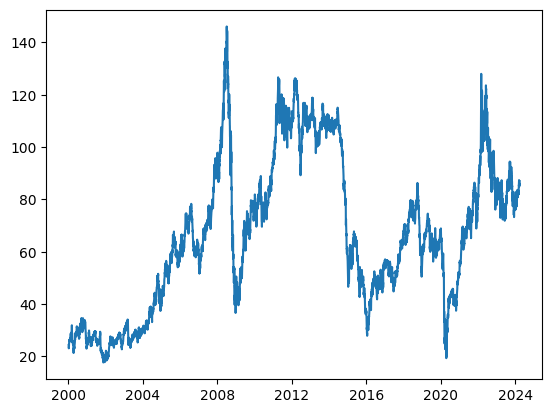

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [ ]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '02/26/2018',
                                '02/26/2019',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2018-02-26,65.42,66.39,67.31,67.50
1,2018-02-27,66.39,67.31,67.50,66.63
2,2018-02-28,67.31,67.50,66.63,65.78
3,2018-03-01,67.50,66.63,65.78,63.83
4,2018-03-02,66.63,65.78,63.83,64.37
...,...,...,...,...,...
254,2019-02-20,66.25,66.50,66.45,67.08
255,2019-02-21,66.50,66.45,67.08,67.07
256,2019-02-22,66.45,67.08,67.07,67.12
257,2019-02-25,67.08,67.07,67.12,64.76


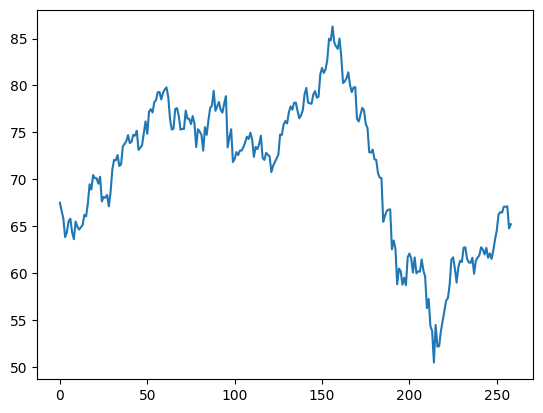

In [ ]:
plt.plot(windowed_df["Target"])

In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((259,), (259, 3, 1), (259,))

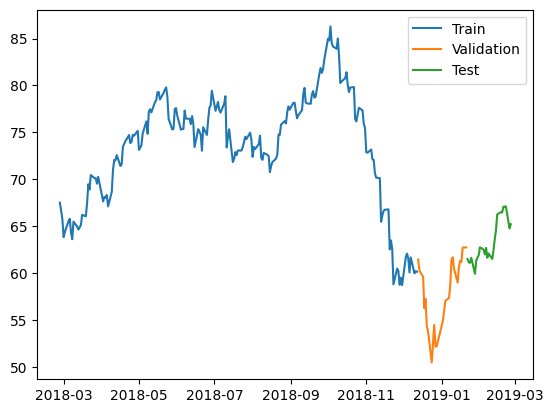

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 3s 99ms/step - loss: 5401.2505 - mean_absolute_error: 73.2488 - val_loss: 3274.5552 - val_mean_absolute_error: 57.1133
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 5306.0615 - mean_absolute_error: 72.5954 - val_loss: 3211.9771 - val_mean_absolute_error: 56.5625
Epoch 3/100
7/7 [==============================] - 0s 9ms/step - loss: 5226.8926 - mean_absolute_error: 72.0451 - val_loss: 3141.7524 - val_mean_absolute_error: 55.9382
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 5127.6631 - mean_absolute_error: 71.3528 - val_loss: 3045.5715 - val_mean_absolute_error: 55.0714
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 4992.2773 - mean_absolute_error: 70.3951 - val_loss: 2910.1206 - val_mean_absolute_error: 53.8270
Epoch 6/100
7/7 [==============================] - 0s 10ms/step - loss: 4795.5317 - mean_absolute_error: 68.9826 - val_loss: 2721.8608 - val_mean_absolut

7/7 [==============================] - 0s 3ms/step


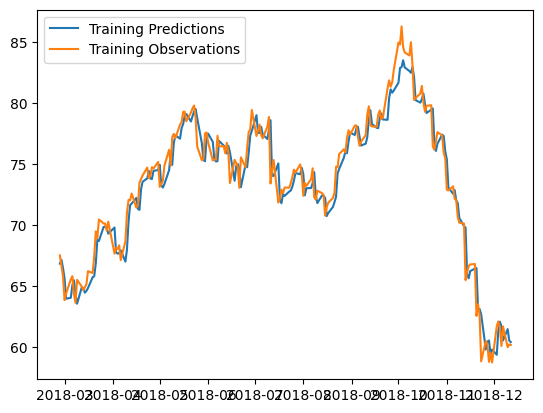

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 23ms/step


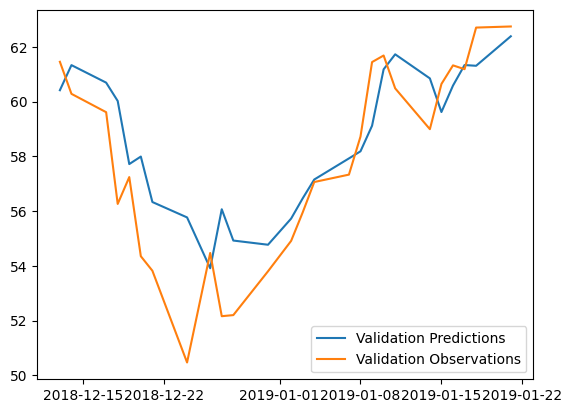

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 37ms/step


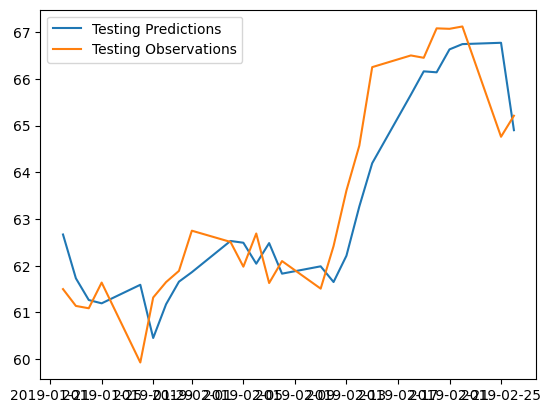

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

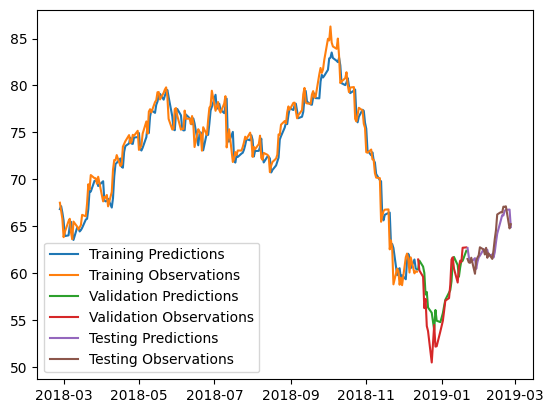

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

last_window = deepcopy(X_train[-1])
for target_date in recursive_dates:
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  for i in range(len(last_window)-1):
    last_window[i] = last_window[i+1]
  last_window[-1] = next_prediction


1/1 [==============================] - 0s 25ms/step


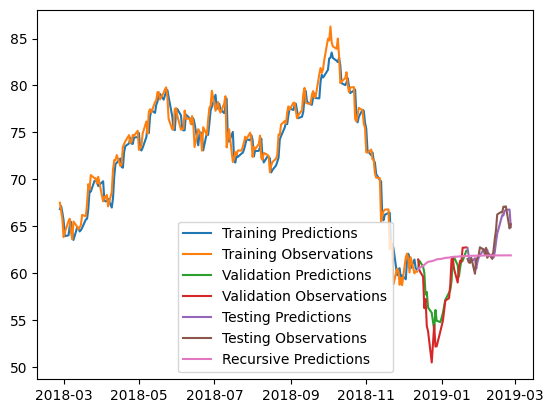

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])

In [ ]:
from copy import deepcopy

recursive_predictions_w_updates = []
recursive_dates_w_updates = np.concatenate([dates_val, dates_test])
real_obs = np.concatenate([y_val, y_test])

last_window = deepcopy(X_train[-1])
idx = 0
for target_date in recursive_dates_w_updates:
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions_w_updates.append(next_prediction)
  for i in range(len(last_window)-1):
    last_window[i] = last_window[i+1]
  last_window[-1] = real_obs[idx]
  idx+=1


1/1 [==============================] - 0s 26ms/step


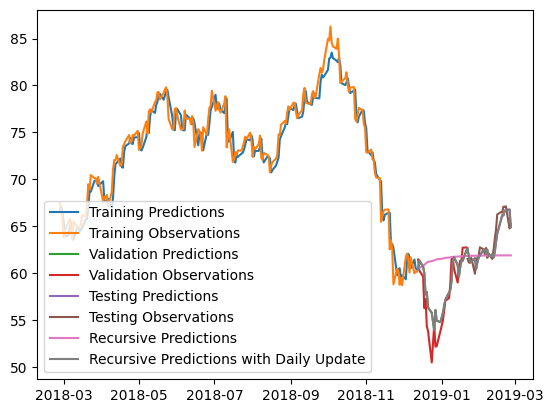

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.plot(recursive_dates_w_updates, recursive_predictions_w_updates)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions',
            'Recursive Predictions with Daily Update'])

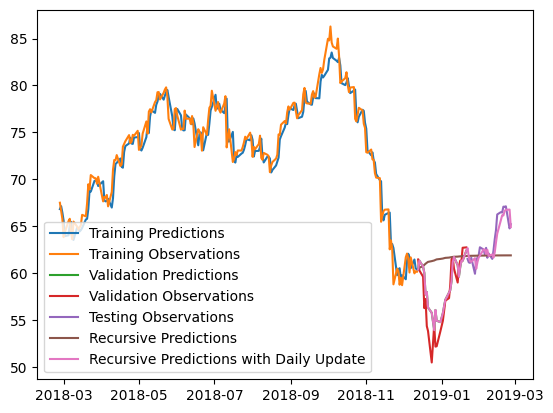

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)

plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.plot(recursive_dates_w_updates, recursive_predictions_w_updates)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',

            'Testing Observations',
            'Recursive Predictions',
            'Recursive Predictions with Daily Update'])